# Анализ работы развлекательного приложения «Procrastinate Pro+»

## Краткое описание проекта 
Объект анализа - развлекательное приложение Procrastinate Pro+. Несколько прошлых месяцев приносли убытки - в привлечение пользователей вложено большое количество денежный средств, однако результата нет. Необходимо разобраться в причинах этой ситуации.

В нашем распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Необходимо изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

### Описание данных

### Таблица visits_log_short (лог сервера с информацией о посещениях сайта):
* User Id — уникальный идентификатор пользователя
* Device — категория устройства пользователя
* Session start — дата и время начала сессии
* Session End — дата и время окончания сессии
* Channel — идентификатор рекламного источника, из которого пришел пользователь
* Region - страна пользователя

### Таблица orders_log_short (информация о заказах):
* User Id — уникальный id пользователя, который сделал заказ
* Event Dt — дата и время покупки
* Revenue — выручка

### Таблица costs_short (информация о затратах на маркетинг):
* Channel — идентификатор рекламного источника
* Dt — дата
* Costs — затраты на этот рекламный источник в этот день

## Обзор данных

Считаем файл, выведем часть строк на экран для знакомства с базой данных:

### Импорт библиотек и базы данных

In [1]:
import pandas as pd                         # Импортируем библиотеки
import seaborn as sns                                           
import math
import matplotlib.pyplot as plt                                
from scipy import stats as st
import numpy as np
from datetime import datetime, timedelta

In [2]:
display(pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv',nrows = 5).head())             # Выведем на экран первые 5 строк 
display(pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv',nrows = 5).head())             # Выведем на экран первые 5 строк 
display(pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv',nrows = 5).head()) 

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Проверив файл, приходим к выводу, что файл корректно считывается, коррекция разделителя столбцов не требуется. Считаем файлы полностью

In [3]:
visits_df = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')                           # Считаем файл
orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')                           # Считаем файл
costs_df = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')                             # Считаем файл
list_df = [visits_df, orders_df, costs_df]

In [4]:
for i in list_df:                                  # Создаем цикл, который пройдет по всем значениям списка list_df
    display(i.head(10))                            # Выведем на экран первые 10 строк
    display(i.info())                              # Выведем на экран общую информацию
    print('    Пропусков по столбцам:')
    display(i.isna().sum())                        # подсчёт пропусков
    #print('    Вывод статистической информации:')
    #round(visits.describe(),2)                    # Выведем на экран статистическую информацию
    print()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
5,90242400005,United States,iPhone,RocketSuperAds,2019-05-01 07:14:52,2019-05-01 08:19:56
6,43958116050,United States,Android,organic,2019-05-01 09:03:21,2019-05-01 10:08:39
7,185365244969,United States,iPhone,organic,2019-05-01 09:37:03,2019-05-01 10:00:43
8,446013509831,United States,iPhone,RocketSuperAds,2019-05-01 10:26:00,2019-05-01 10:59:17
9,100970711362,United States,Mac,TipTop,2019-05-01 04:39:53,2019-05-01 04:57:05


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

    Пропусков по столбцам:


User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
5,129100331057,2019-05-01 01:56:28,4.99
6,626807144131,2019-05-01 02:39:21,4.99
7,914062168985,2019-05-01 02:02:18,4.99
8,769669137453,2019-05-01 03:39:47,4.99
9,434198630691,2019-05-01 18:16:50,5.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

    Пропусков по столбцам:


User Id     0
Event Dt    0
Revenue     0
dtype: int64

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
5,2019-05-06,FaceBoom,118.8
6,2019-05-07,FaceBoom,101.2
7,2019-05-08,FaceBoom,100.1
8,2019-05-09,FaceBoom,93.5
9,2019-05-10,FaceBoom,104.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

    Пропусков по столбцам:


dt         0
Channel    0
costs      0
dtype: int64

Промежуточный вывод: названия столбцов не соответствуют змеиному регистру, все столбцы с датами имеют текстовый тип.

Проверим данные на наличие явных и неявных дубликатов:

In [5]:
for i in list_df:                                         # Создаем цикл, который пройдет по всем значениям списка list_df
    print('Явных дубликатов: ',i.duplicated().sum())      # Вывод количества явных дубликатов

Явных дубликатов:  0
Явных дубликатов:  0
Явных дубликатов:  0


In [6]:
# При помощи метода .value_counts() возвратим перечень уникальных значений и их кол-во
for i in [visits_df['Region'],visits_df['Device'],visits_df['Channel'],costs_df['Channel']]:
    display(i.value_counts())

United States    207327
UK                36419
France            35396
Germany           30759
Name: Region, dtype: int64

iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: Device, dtype: int64

organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: Channel, dtype: int64

FaceBoom              180
MediaTornado          180
RocketSuperAds        180
TipTop                180
YRabbit               180
AdNonSense            180
LeapBob               180
OppleCreativeMedia    180
WahooNetBanner        180
lambdaMediaAds        180
Name: Channel, dtype: int64

Промежуточный вывод: неявных дубликатов, которые могли бы значительно повлиять на результаты исследования, не выявлено.

По данным информации, отображенной на экране в предыдущей ячейке, можно сделать план предобработки данных:

### План предобработки: 
* привести названия столбцов к нижнему регистру;
* столбцы с датами привести к соответствующему типу.

## Предобработка

### Переименование столбцов
Изменим названия столбцов (в соответствие со змеиным регистром):

In [7]:
for i in list_df:                                         # Создаем цикл, который пройдет по всем значениям списка list_df
    print('До:',i.columns)
    i.columns = i.columns.str.lower()
    print('После:',i.columns)
    print()

До: Index(['User Id', 'Region', 'Device', 'Channel', 'Session Start',
       'Session End'],
      dtype='object')
После: Index(['user id', 'region', 'device', 'channel', 'session start',
       'session end'],
      dtype='object')

До: Index(['User Id', 'Event Dt', 'Revenue'], dtype='object')
После: Index(['user id', 'event dt', 'revenue'], dtype='object')

До: Index(['dt', 'Channel', 'costs'], dtype='object')
После: Index(['dt', 'channel', 'costs'], dtype='object')



In [8]:
visits_df = visits_df.rename(columns={'user id':'user_id','session start':'session_start','session end':'session_end'})
print('Итого:',visits_df.columns)
orders_df = orders_df.rename(columns={'user id':'user_id','event dt':'event_dt'})
print('Итого:',orders_df.columns)

Итого: Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')
Итого: Index(['user_id', 'event_dt', 'revenue'], dtype='object')


Промежуточный вывод: переименование завершено успешно.

### Изменение типа
Необходимо столбцы с датами привести к соответствующему типу:

In [9]:
visits_df['session_start']=pd.to_datetime(visits_df['session_start'])
print('Тип:',visits_df['session_start'].dtype)

visits_df['session_end']=pd.to_datetime(visits_df['session_end'])
print('Тип:',visits_df['session_start'].dtype) 

orders_df['event_dt']=pd.to_datetime(orders_df['event_dt'])
print('Тип:',orders_df['event_dt'].dtype)

costs_df['dt']=pd.to_datetime(costs_df['dt'])
print('Тип:',costs_df['dt'].dtype) 

Тип: datetime64[ns]
Тип: datetime64[ns]
Тип: datetime64[ns]
Тип: datetime64[ns]


Промежуточный вывод: предобработка завершена успешно.

### Итоговые датафреймы для работы
Для дальнейшего удобства ещё раз выведем на экран по пять первых строк датафреймов:

In [10]:
display(visits_df.head(5))
visits_df.info()

display(orders_df.head(5))
orders_df.info()

display(costs_df.head(5))
costs_df.info()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


## Подготовка данных

### Таблица пользовательских профилей
Осуществим формирование пользовательских профилей:

In [11]:
def get_profiles(sessions, orders, ad_costs):

# находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start']).groupby('user_id')
        .agg({'session_start': 'first', 'channel': 'first', 'device': 'first', 'region': 'first'})
        .rename(columns={'session_start': 'first_ts'}).reset_index())

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['dt']=pd.to_datetime(profiles['dt'])

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей с одинаковыми источником и датой привлечения
    new_users = (profiles.groupby(['dt', 'channel']).agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'}).reset_index())
    new_users['dt']=pd.to_datetime(new_users['dt'])

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], on=['dt', 'channel'], how='left')

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

profiles=get_profiles(visits_df, orders_df, costs_df)

profiles.head(10)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:23,organic,Android,United States,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,False,0.000000
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435


Промежуточный вывод: таблица пользовательских профилей построена. 

### Определение момента анализа и горизонта анализа
Для последующих расчетов выберем горизонт анализа в размере 15 дней в соответствие с положением бизнес-плана компании, регламентриующего необходимость окупаемости рекламы в течение 15 дней. 

Момент анализа в соответствие заданию определим на 01 ноября 2019 года

In [12]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 15

display(observation_date)   
horizon_days

datetime.date(2019, 11, 1)

15

### Расчёт удержания
При помощи функции get_retention осуществим расчет показателя Retention Rate c дифференциацией по стране, источнику пользователей и дате первой сессии:

In [13]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

          
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#dimensions=['region','channel']
dimensions=['channel']
#dimensions=['region']

result_raw_from_retention, result_grouped_from_retention, result_in_time_from_retention = get_retention(
    profiles, visits_df, observation_date, horizon_days, dimensions)

#display(result_raw_from_retention.head(10))
display(result_grouped_from_retention.head(20))
display(result_in_time_from_retention.head(20))

cohort_size    0         1         2         3  \
payer channel                                                              
False AdNonSense                 3274  1.0  0.176237  0.087355  0.051313   
      FaceBoom                  24015  1.0  0.173142  0.087196  0.050802   
      LeapBob                    7807  1.0  0.171128  0.090944  0.051236   
      MediaTornado               4000  1.0  0.183000  0.082000  0.056000   
      OppleCreativeMedia         7859  1.0  0.172159  0.089070  0.053315   
      RocketSuperAds             3892  1.0  0.175745  0.086074  0.051131   
      TipTop                    16593  1.0  0.181281  0.084614  0.050985   
      WahooNetBanner             7606  1.0  0.184328  0.084670  0.053247   
      YRabbit                    3922  1.0  0.180010  0.083376  0.049465   
      lambdaMediaAds             1829  1.0  0.183707  0.086933  0.062876   
      organic                   52551  1.0  0.176895  0.085840  0.050998   
True  AdNonSense                  413  1.0  0.285714  0.162228  0.130751   
      FaceBoom                   3334  1.0  0.221656  0.123275  0.074985   
      LeapBob                     240  1.0  0.550000  0.491667  0.400000   
      MediaTornado                148  1.0  0.500000  0.452703  0.351351   
      OppleCreativeMedia          219  1.0  0.534247  0.461187  0.401826   
      RocketSuperAds              333  1.0  0.573574  0.468468  0.399399   
      TipTop                     1774  1.0  0.534386  0.463360  0.408681   
      WahooNetBanner              423  1.0  0.557920  0.510638  0.392435   
      YRabbit                     155  1.0  0.561290  0.380645  0.400000   

                                 4         5         6         7         8  \
payer channel                                                                
False AdNonSense          0.037263  0.021686  0.018937  0.016799  0.011301   
      FaceBoom            0.032688  0.025151  0.019696  0.013616  0.011909   
      LeapBob             0.032535  0.023184  0.018957  0.014602  0.010888   
      MediaTornado        0.028750  0.025000  0.018500  0.011750  0.016000   
      OppleCreativeMedia  0.032192  0.026339  0.019214  0.014506  0.011834   
      RocketSuperAds      0.035457  0.020812  0.014902  0.016444  0.008479   
      TipTop              0.034954  0.025854  0.018743  0.013922  0.011812   
      WahooNetBanner      0.034184  0.022219  0.017486  0.015120  0.011701   
      YRabbit             0.034931  0.023202  0.016063  0.014023  0.009434   
      lambdaMediaAds      0.033352  0.031165  0.015856  0.014215  0.010935   
      organic             0.036060  0.024224  0.018154  0.013739  0.011988   
True  AdNonSense          0.077482  0.060533  0.058111  0.048426  0.055690   
      FaceBoom            0.057888  0.041392  0.038692  0.028194  0.020096   
      LeapBob             0.333333  0.387500  0.287500  0.250000  0.270833   
      MediaTornado        0.344595  0.351351  0.250000  0.229730  0.216216   
      OppleCreativeMedia  0.397260  0.315068  0.333333  0.273973  0.237443   
      RocketSuperAds      0.396396  0.327327  0.321321  0.321321  0.264264   
      TipTop              0.351747  0.346674  0.290304  0.286922  0.277903   
      WahooNetBanner      0.449173  0.385343  0.338061  0.347518  0.312057   
      YRabbit             0.367742  0.277419  0.264516  0.225806  0.264516   

                                 9        10        11        12        13  \
payer channel                                                                
False AdNonSense          0.011301  0.006109  0.005498  0.007025  0.006720   
      FaceBoom            0.009994  0.008120  0.005455  0.006663  0.004372   
      LeapBob             0.010503  0.007301  0.006661  0.005380  0.004867   
      MediaTornado        0.008500  0.007250  0.009000  0.004500  0.005000   
      OppleCreativeMedia  0.008398  0.008144  0.005471  0.007253  0.005726   
      RocketSuperAds      0.007708  0.007194  0.008479  0.003854  0.002826   
      TipTop

cohort_size    0         1         2         3  \
payer channel    dt                                                           
False AdNonSense 2019-05-01           36  1.0  0.222222  0.000000  0.111111   
                 2019-05-02           36  1.0  0.111111  0.083333  0.027778   
                 2019-05-03           42  1.0  0.142857  0.095238  0.047619   
                 2019-05-04           45  1.0  0.133333  0.066667  0.044444   
                 2019-05-05           31  1.0  0.322581  0.064516  0.064516   
                 2019-05-06           36  1.0  0.250000  0.083333  0.083333   
                 2019-05-07           26  1.0  0.269231  0.076923  0.000000   
                 2019-05-08           30  1.0  0.200000  0.066667  0.000000   
                 2019-05-09           34  1.0  0.176471  0.058824  0.088235   
                 2019-05-10           38  1.0  0.236842  0.078947  0.078947   
                 2019-05-11           27  1.0  0.148148  0.111111  0.037037   
                 2019-05-12           42  1.0  0.119048  0.095238  0.047619   
                 2019-05-13           39  1.0  0.128205  0.076923  0.153846   
                 2019-05-14           34  1.0  0.264706  0.176471  0.088235   
                 2019-05-15           20  1.0  0.200000  0.000000  0.050000   
                 2019-05-16           31  1.0  0.161290  0.000000  0.129032   
                 2019-05-17           32  1.0  0.218750  0.093750  0.062500   
                 2019-05-18           43  1.0  0.186047  0.139535  0.046512   
                 2019-05-19           44  1.0  0.159091  0.045455  0.045455   
                 2019-05-20           34  1.0  0.205882  0.058824  0.058824   

                                    4         5         6         7         8  \
payer channel    dt                                                             
False AdNonSense 2019-05-01  0.027778  0.000000  0.027778  0.000000  0.000000   
                 2019-05-02  0.027778  0.000000  0.055556  0.000000  0.055556   
                 2019-05-03  0.023810  0.023810  0.047619  0.023810  0.000000   
                 2019-05-04  0.022222  0.022222  0.000000  0.000000  0.000000   
                 2019-05-05  0.032258  0.000000  0.032258  0.000000  0.000000   
                 2019-05-06  0.055556  0.000000  0.000000  0.055556  0.000000   
                 2019-05-07  0.038462  0.000000  0.038462  0.038462  0.000000   
                 2019-05-08  0.033333  0.000000  0.000000  0.000000  0.000000   
                 2019-05-09  0.088235  0.029412  0.000000  0.000000  0.000000   
                 2019-05-10  0.052632  0.052632  0.078947  0.000000  0.026316   
                 2019-05-11  0.037037  0.000000  0.000000  0.037037  0.037037   
                 2019-05-12  0.023810  0.000000  0.000000  0.095238  0.047619   
                 2019-05-13  0.051282  0.000000  0.025641  0.000000  0.000000   
                 2019-05-14  0.029412  0.058824  0.000000  0.000000  0.000000   
                 2019-05-15  0.050000  0.100000  0.000000  0.000000  0.000000   
                 2019-05-16  0.064516  0.000000  0.000000  0.000000  0.000000   
                 2019-05-17  0.031250  0.031250  0.062500  0.000000  0.000000   
                 2019-05-18  0.069767  0.046512  0.000000  0.023256  0.023256   
                 2019-05-19  0.045455  0.068182  0.022727  0.022727  0.022727   
                 2019-05-20  0.000000  0.000000  0.000000  0.000000  0.000000   

                                    9        10        11        12        13  \
payer channel    dt                                                             
False AdNonSense 2019-05-01  0.027778  0.000000  0.000000  0.000000  0.027778   
                 2019-05-02  0.000000  0.000000  0.055556  0.055556  0.027778   
                 2019-05-03  0.000000  0.000000  0.000000  0.000000  0.000000   
                 2019-05-04  0.000000  0.000000  0.000000  0.000000  0.000000   
                 2019

Промежуточный вывод: таблица удержания построена.

### Расчёт конверсии

При помощи функции get_conversion осуществим расчет конверсии:


In [14]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

purchases = orders_df
result_raw_from_conversion, result_grouped_from_conversion, result_in_time_from_conversion = get_conversion(
    profiles, purchases, observation_date, horizon_days, dimensions=[])

#display(result_raw_from_conversion.head(10))
display(result_grouped_from_conversion.head(10))
display(result_in_time_from_conversion.head(10))

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
cohort,,,,,,,,,,,,,,,,
All users,141709,0.040901,0.046694,0.049496,0.051486,0.052939,0.053857,0.05464,0.055353,0.055903,0.056418,0.056701,0.056934,0.057096,0.057322,0.05747


,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
dt,,,,,,,,,,,,,,,,
2019-05-01,909,0.031903,0.036304,0.038504,0.038504,0.040704,0.040704,0.040704,0.041804,0.042904,0.044004,0.044004,0.044004,0.044004,0.045105,0.045105
2019-05-02,758,0.029024,0.035620,0.036939,0.036939,0.036939,0.036939,0.036939,0.038259,0.038259,0.038259,0.039578,0.039578,0.039578,0.039578,0.039578
2019-05-03,849,0.031802,0.037691,0.043581,0.044759,0.047114,0.047114,0.047114,0.047114,0.047114,0.047114,0.047114,0.047114,0.047114,0.048292,0.048292
2019-05-04,1015,0.035468,0.039409,0.040394,0.042365,0.047291,0.047291,0.048276,0.050246,0.051232,0.052217,0.052217,0.052217,0.052217,0.052217,0.052217
2019-05-05,970,0.023711,0.026804,0.028866,0.030928,0.032990,0.032990,0.032990,0.032990,0.032990,0.032990,0.032990,0.032990,0.032990,0.032990,0.032990
2019-05-06,1014,0.032544,0.042406,0.045365,0.049310,0.051282,0.052268,0.054241,0.054241,0.054241,0.056213,0.058185,0.058185,0.059172,0.061144,0.061144
2019-05-07,888,0.031532,0.036036,0.040541,0.041667,0.041667,0.041667,0.042793,0.045045,0.046171,0.046171,0.046171,0.046171,0.046171,0.046171,0.046171
2019-05-08,782,0.035806,0.040921,0.042199,0.043478,0.044757,0.047315,0.047315,0.048593,0.048593,0.048593,0.048593,0.048593,0.048593,0.048593,0.048593
2019-05-09,801,0.036205,0.042447,0.044944,0.044944,0.044944,0.046192,0.047441,0.047441,0.047441,0.048689,0.048689,0.049938,0.049938,0.049938,0.049938


Промежуточный вывод: таблица конверсии построена.

### Расчёт LTV и ROI
При помощи функции get_ltv осуществим расчет общей выручки на каждого клиента (LTV) и окупаемость инвестиций (ROI):

In [15]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

result_raw_from_roi, result_grouped_from_roi, result_in_time_from_roi, roi_grouped, roi_in_time = get_ltv(
    profiles, purchases, observation_date, horizon_days, dimensions=[])

#display(result_raw_from_roi.head(10))
display(roi_grouped.head(10))
display(roi_in_time.head(10))

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
cohort,,,,,,,,,,,,,,,,,
All users,141709,0.693668,0.347805,0.448273,0.524804,0.588837,0.644951,0.6944,0.739841,0.780476,0.820253,0.856836,0.890363,0.92186,0.952781,0.981027,1.009581


,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
dt,,,,,,,,,,,,,,,,,
2019-05-01,909,0.335336,0.478020,0.641723,0.775966,0.877469,0.942950,0.942950,0.975691,1.008431,1.139394,1.270455,1.401417,1.499639,1.516009,1.565120,1.597861
2019-05-02,758,0.304545,0.518790,0.994737,1.102818,1.254132,1.340597,1.448721,1.491953,1.621651,1.729732,1.794581,1.881046,1.902662,1.945894,2.010743,2.097208
2019-05-03,849,0.309859,0.534915,0.804273,1.054662,1.225377,1.624054,1.775839,1.794807,1.813776,1.908617,2.003459,2.041396,2.155206,2.231079,2.287984,2.306953
2019-05-04,1015,0.332020,0.699169,0.862047,0.950890,1.084184,1.383561,1.561246,1.590861,1.679703,1.753739,1.812967,1.857389,1.975846,1.975846,2.079496,2.168338
2019-05-05,970,0.329799,0.427439,0.696019,0.742814,0.805208,0.883200,0.961192,1.007987,1.054782,1.070380,1.101577,1.179569,1.210766,1.273159,1.288758,1.335553
2019-05-06,1014,0.320330,0.537691,0.755846,0.909472,1.063097,1.170636,1.232086,1.416468,1.462556,1.585456,1.723720,1.800533,1.941905,2.034081,2.141619,2.187707
2019-05-07,888,0.315203,0.698964,0.877242,1.073348,1.215970,1.322937,1.394248,1.501215,1.590354,1.643837,1.786459,1.839943,1.857771,1.893426,1.946945,1.964773
2019-05-08,782,0.331963,0.557445,0.711223,0.865040,0.903484,1.003448,1.138003,1.214892,1.330264,1.349487,1.349487,1.407153,1.445598,1.484042,1.503265,1.580154
2019-05-09,801,0.304207,0.618459,0.864202,0.946116,1.048508,1.216440,1.318833,1.421225,1.503139,1.605532,1.666968,1.687446,1.748882,1.810317,1.851274,1.912710


Промежуточный вывод: таблица выручки и окупаемости построена.

## Исследовательский анализ данных
### Ключевые показатели
Согласно заданию необходимо определить:
- Минимальную и максимальную дату привлечения пользователей. 
- Из каких стран приходят посетители, какие страны дают больше всего платящих пользователей.
- Какими устройствами пользуются посетители, с каких устройств чаще всего заходят платящие пользователи.
- По каким рекламным каналам шло привлечение пользователей, какие каналы приносят больше всего платящих пользователей.

- Объем денежных средств, потраченных на рекламу (общий);
- Объем денежных средств потраченных с дифференциацией по источникам и по времени.
- Сколько в среднем стоило привлечение одного покупателя из каждого источника.

Выведем на экран ответы на все эти вопросы:

In [20]:
print('Мин. дата привлечения пользователей:',profiles['first_ts'].min(),', макс: ',profiles['first_ts'].max())

Мин. дата привлечения пользователей: 2019-05-01 00:00:41 , макс:  2019-10-27 23:59:04


In [21]:
print('Количество пользователей с дифференциацией по странам (всего, в том числе платящих, их доля):')
profiles.groupby('region').agg({'payer':['count','sum','mean']})

Количество пользователей с дифференциацией по странам (всего, в том числе платящих, их доля):


payer                
                count   sum      mean
region                               
France          17450   663  0.037994
Germany         14981   616  0.041119
UK              17575   700  0.039829
United States  100002  6902  0.069019

In [19]:
print('Количество пользователей с дифференциацией по устройствам (всего, в том числе платящих, их доля):')
profiles.groupby('device').agg({'payer':['count','sum','mean']})

Количество пользователей с дифференциацией по устройствам (всего, в том числе платящих, их доля):


payer                
         count   sum      mean
device                        
Android  35032  2050  0.058518
Mac      30042  1912  0.063644
PC       30455  1537  0.050468
iPhone   54479  3382  0.062079

In [22]:
print('Количество пользователей с дифференциацией по каналам (всего, в том числе платящих, их доля):')
profiles.groupby('channel').agg({'payer':['count','sum','mean']})

Количество пользователей с дифференциацией по каналам (всего, в том числе платящих, их доля):


payer                
                    count   sum      mean
channel                                  
AdNonSense           3880   440  0.113402
FaceBoom            29144  3557  0.122049
LeapBob              8553   262  0.030633
MediaTornado         4364   156  0.035747
OppleCreativeMedia   8605   233  0.027077
RocketSuperAds       4448   352  0.079137
TipTop              19561  1878  0.096007
WahooNetBanner       8553   453  0.052964
YRabbit              4312   165  0.038265
lambdaMediaAds       2149   225  0.104700
organic             56439  1160  0.020553

In [23]:
print('Всего израсходовано на рекламу:',round(costs_df['costs'].sum()))

Всего израсходовано на рекламу: 105497


In [24]:
print('Затраты денежных средств на рекламу с дифференциацией по источникам:')
model=costs_df.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)
model['%']=model['costs']/model['costs'].sum()*100
display(model)

Затраты денежных средств на рекламу с дифференциацией по источникам:


,costs,%
channel,,
TipTop,54751.30,51.898295
FaceBoom,32445.60,30.754910
WahooNetBanner,5151.00,4.882589
AdNonSense,3911.25,3.707441
OppleCreativeMedia,2151.25,2.039152
RocketSuperAds,1833.00,1.737485
LeapBob,1797.60,1.703930
lambdaMediaAds,1557.60,1.476436
MediaTornado,954.48,0.904744


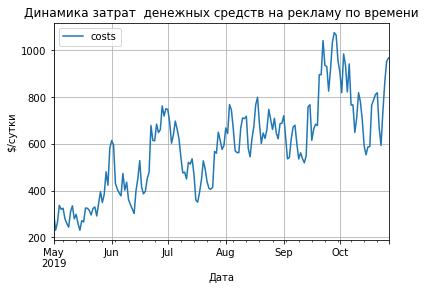

In [25]:
costs_df.groupby('dt').agg({'costs':'sum'}).sort_values(by='dt', ascending=True).plot(grid=True, title='Динамика затрат  денежных средств на рекламу по времени')
plt.legend()
plt.ylabel('$/сутки')
plt.xlabel('Дата')
plt.show()
#print(costs_df.head(15))


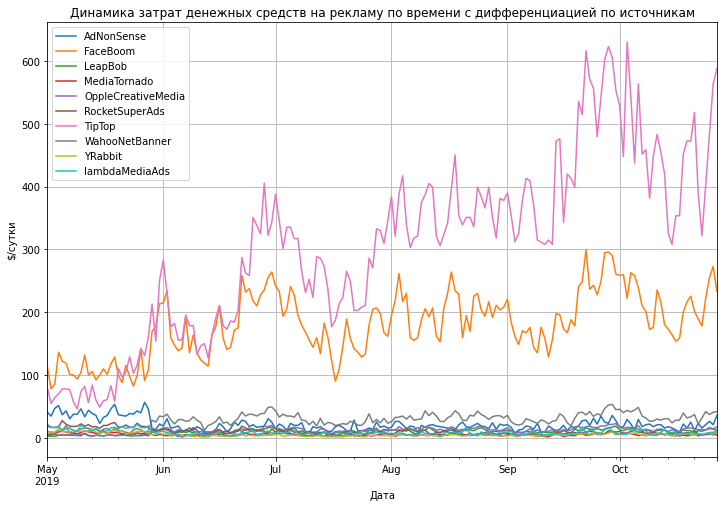

In [26]:
costs_df.pivot_table(index='dt',columns='channel',values='costs',aggfunc='sum').plot(
    grid=True, title='Динамика затрат денежных средств на рекламу по времени с дифференциацией по источникам',figsize=(12,8))
plt.legend()
plt.ylabel('$/сутки')
plt.xlabel('Дата')
plt.show()

Как видно из последнего графика, большинство (82,6%) денежных средств направлялась на покупку пользователей именно из проблематичных (неокупаемых) источников - 'TipTop' и 'FaceBoom'. Это и есть главная причина кризиса компании.
Источник 'AdNonSense' хотя и входит в число проблематичных, но на него денежных средств выделялось сравнительно мало (3,7% от общей суммы).

Выведем на экран среднюю сумму привлечения одного покупателя из каждого источника:

In [27]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

result_raw_from_roi_, result_grouped_from_roi_, result_in_time_from_roi_, roi_grouped_, roi_in_time_ = get_ltv(
    profiles, purchases, observation_date, horizon_days, dimensions=[])

#display(roi_grouped_['cac'].head(20).sort_values(ascending=False))
display(roi_in_time_.head(10))

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
dt,,,,,,,,,,,,,,,,,
2019-05-01,909,0.335336,0.478020,0.641723,0.775966,0.877469,0.942950,0.942950,0.975691,1.008431,1.139394,1.270455,1.401417,1.499639,1.516009,1.565120,1.597861
2019-05-02,758,0.304545,0.518790,0.994737,1.102818,1.254132,1.340597,1.448721,1.491953,1.621651,1.729732,1.794581,1.881046,1.902662,1.945894,2.010743,2.097208
2019-05-03,849,0.309859,0.534915,0.804273,1.054662,1.225377,1.624054,1.775839,1.794807,1.813776,1.908617,2.003459,2.041396,2.155206,2.231079,2.287984,2.306953
2019-05-04,1015,0.332020,0.699169,0.862047,0.950890,1.084184,1.383561,1.561246,1.590861,1.679703,1.753739,1.812967,1.857389,1.975846,1.975846,2.079496,2.168338
2019-05-05,970,0.329799,0.427439,0.696019,0.742814,0.805208,0.883200,0.961192,1.007987,1.054782,1.070380,1.101577,1.179569,1.210766,1.273159,1.288758,1.335553
2019-05-06,1014,0.320330,0.537691,0.755846,0.909472,1.063097,1.170636,1.232086,1.416468,1.462556,1.585456,1.723720,1.800533,1.941905,2.034081,2.141619,2.187707
2019-05-07,888,0.315203,0.698964,0.877242,1.073348,1.215970,1.322937,1.394248,1.501215,1.590354,1.643837,1.786459,1.839943,1.857771,1.893426,1.946945,1.964773
2019-05-08,782,0.331963,0.557445,0.711223,0.865040,0.903484,1.003448,1.138003,1.214892,1.330264,1.349487,1.349487,1.407153,1.445598,1.484042,1.503265,1.580154
2019-05-09,801,0.304207,0.618459,0.864202,0.946116,1.048508,1.216440,1.318833,1.421225,1.503139,1.605532,1.666968,1.687446,1.748882,1.810317,1.851274,1.912710


In [28]:
profiles_filter = profiles.query('channel not in ["organic"]') # фильтруем уже имеющийся profiles
#display(profiles_d.head(20))
result_raw_from_roi_a, result_grouped_from_roi_a, result_in_time_from_roi_a, roi_grouped_a, roi_in_time_a = get_ltv(
    profiles_filter, purchases, observation_date, horizon_days, dimensions=[])
display(roi_grouped_a['cac'].head(20))

cohort
All users    1.116323
Name: cac, dtype: float64

### Удержание
#### Общее удержание
Сделаем визуализацию общего показателя Retention Rate:

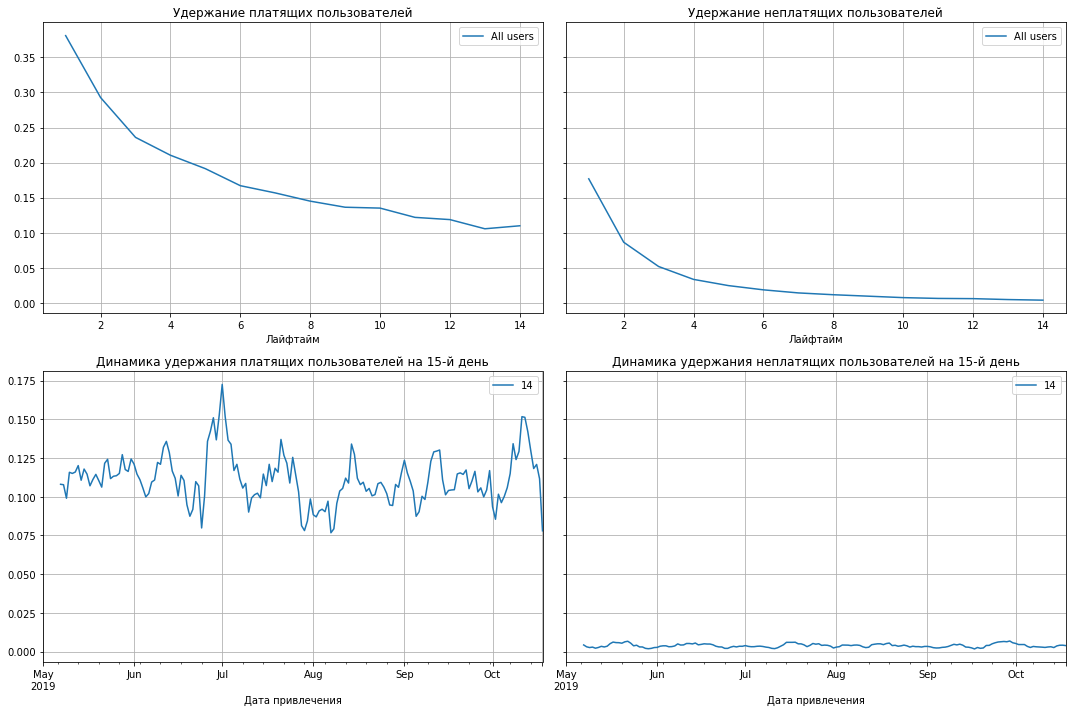

In [29]:
profiles = profiles.query('channel != "organic"')

# функция для визуализации удержания
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 
    
#plot_retention(result_grouped_from_retention, result_in_time_from_retention, 15)

# [],['region'],['device'],['channel']

result_raw_from_retention, result_grouped_from_retention, result_in_time_from_retention = get_retention(
    profiles, visits_df, observation_date, horizon_days, dimensions=[])
    
plot_retention(result_grouped_from_retention, result_in_time_from_retention, 15)


Промежуточный вывод: график среднего удержания построен.

Можно отметить, что общее удержание среди платящих пользователей в среднем снижается с 0,37 до 0,12.

#### По странам
Сделаем визуализацию показателя Retention Rate c дифференциацией по странам:

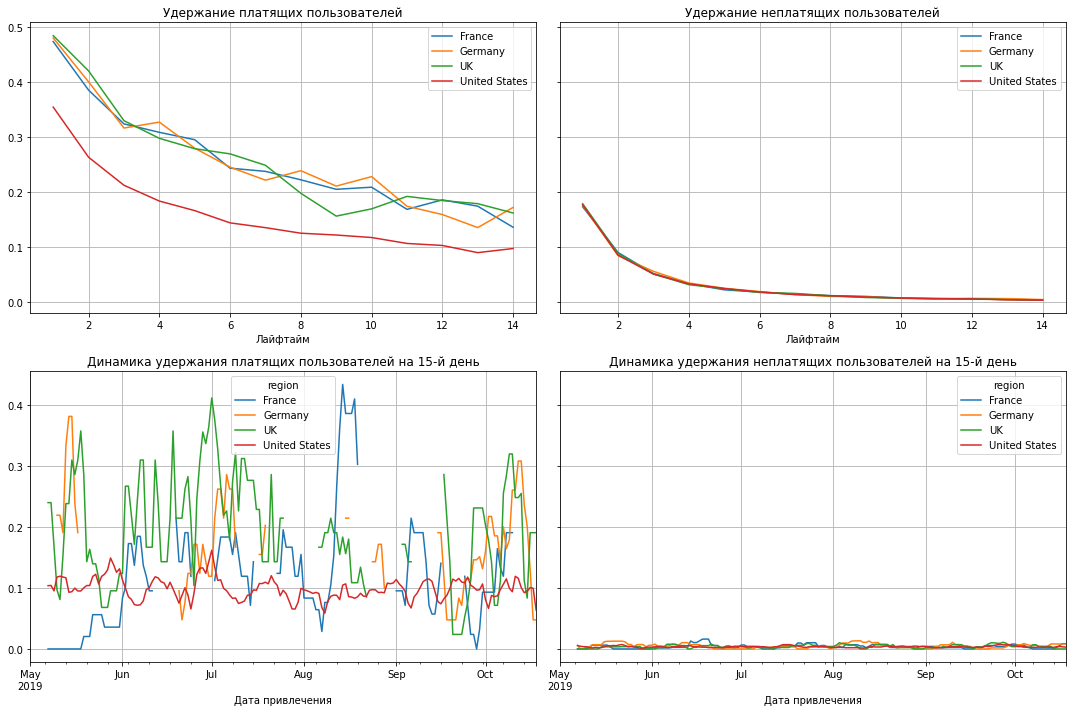

In [30]:
# [],['region'],['device'],['channel']
result_raw_from_retention, result_grouped_from_retention, result_in_time_from_retention = get_retention(
    profiles, visits_df, observation_date, horizon_days, dimensions=['region'])
    
plot_retention(result_grouped_from_retention, result_in_time_from_retention, 15)

Промежуточный вывод: графики удержания с дифференциацией по странам построен.
Прежде всего необходимо отметить, что при построении графика с дифференциацией по странам, удержание платящих пользователей из Франции, Германии и Великобритании составило 0,48-0,16 (для сравнения на общем графике этот показатель составлял всего 0,37-0,12), то есть общее удержание в среднем по странам значительно снизило доля пользователей из США. 
В свою очередь, низкое удержание пользователей из США, объясняется большой долей источника 'FaceBoom' по этой стране и из ряда вон низким удержанием этого источника (см. удержание по источникам).

#### По устройствам
Сделаем визуализацию показателя Retention Rate c дифференциацией по устройствам:

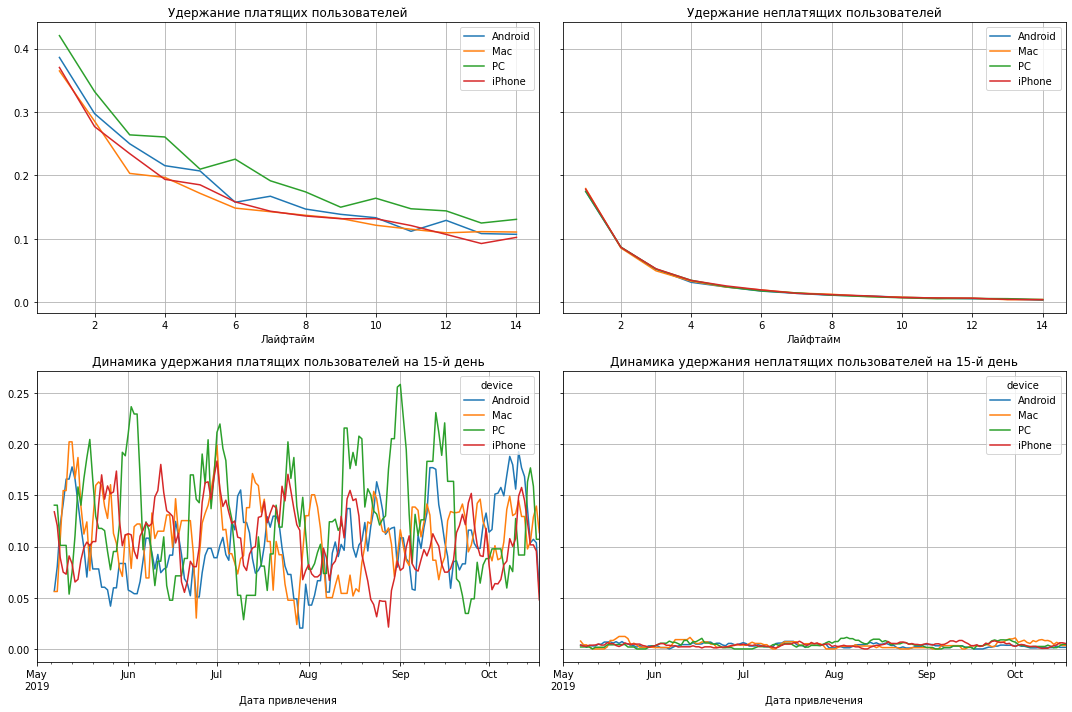

In [32]:
# [],['region'],['device'],['channel']
result_raw_from_retention, result_grouped_from_retention, result_in_time_from_retention = get_retention(
    profiles, visits_df, observation_date, horizon_days, dimensions=['device'])
    
plot_retention(result_grouped_from_retention, result_in_time_from_retention, 15)

Промежуточный вывод: графики удержания с дифференциацией по устройствам построен. 

Удержание пользователи, использующих различные устройства, ведут себя примерно одинаково. Следовательно, нет оснований говорить о наличии каких-либо технических проблем, связанных с неудовлетворительной работой приложения на каках-либо устройствах.

#### По источникам
Сделаем визуализацию показателя Retention Rate c дифференциацией по источникам:

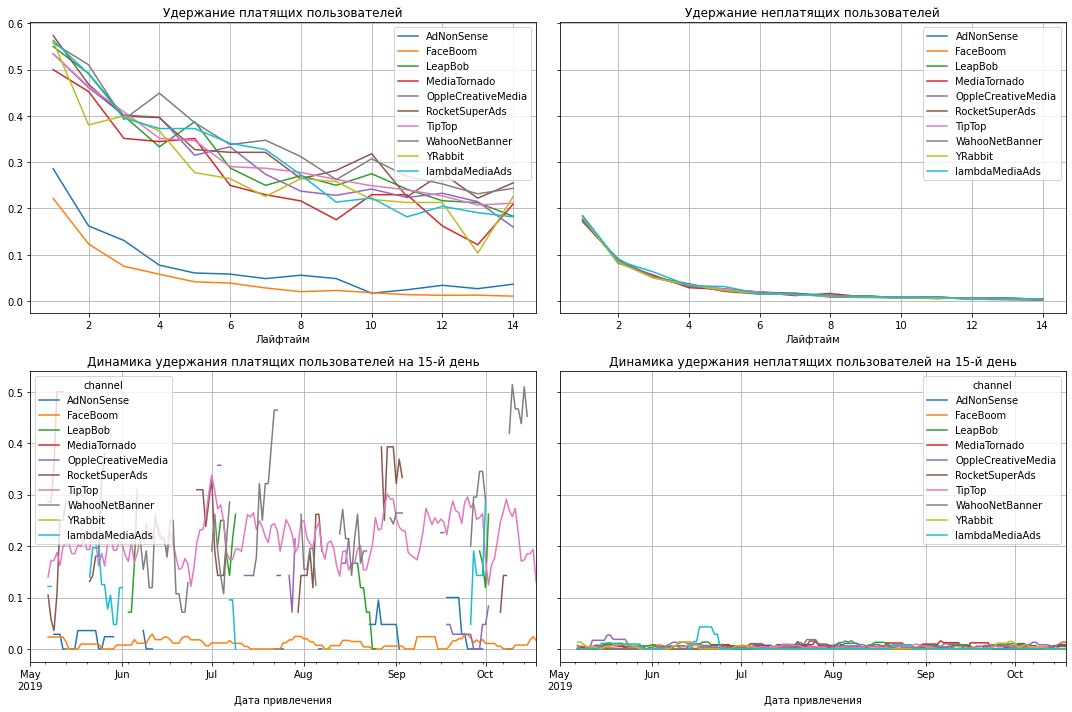

In [33]:
# [],['region'],['device'],['channel']
result_raw_from_retention, result_grouped_from_retention, result_in_time_from_retention = get_retention(
    profiles, visits_df, observation_date, horizon_days, dimensions=['channel'])
    
plot_retention(result_grouped_from_retention, result_in_time_from_retention, 15)

Промежуточный вывод: визуализация удержания построена.

Выделяется крайне низкое удержание пользователей из источников 'AdNonSense' и 'FaceBoom' (США), при этом доля первого источника по привлечению платящих пользователей составила всего 5,7 %, в второго - 46% (не считая organic):

In [34]:
print('Вклад источников по количеству платящих пользователей(за исключением organic):')
model=profiles.groupby('channel').agg({'payer':'sum'}).sort_values(by='payer', ascending=False)
model['%']=model['payer']/model['payer'].sum()*100
display(model)

Вклад источников по количеству платящих пользователей(за исключением organic):


,payer,%
channel,,
FaceBoom,3557,46.069162
TipTop,1878,24.323274
WahooNetBanner,453,5.867116
AdNonSense,440,5.698744
RocketSuperAds,352,4.558995
LeapBob,262,3.393343
OppleCreativeMedia,233,3.017744
lambdaMediaAds,225,2.914130
YRabbit,165,2.137029


### Конверсия
#### Общая конверсия
Сделаем визуализацию общего показателя конверсии:

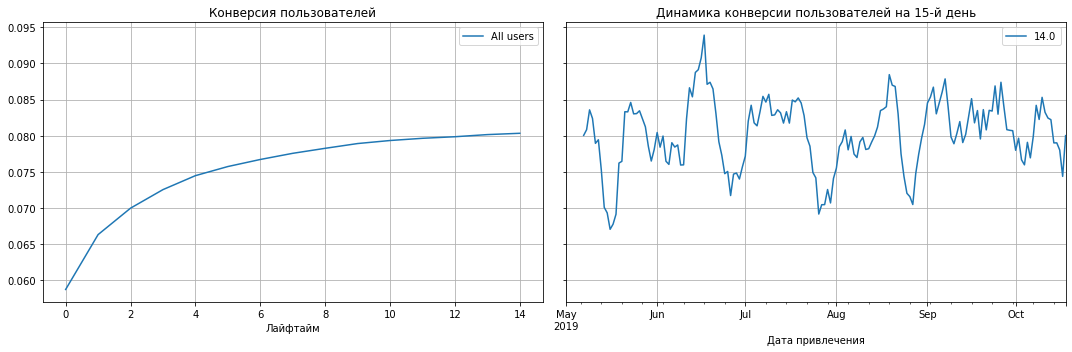

In [35]:
# функция для визуализации конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 
    
# [],['region'],['device'],['channel']    
result_raw_from_conversion, result_grouped_from_conversion, result_in_time_from_conversion = get_conversion(
    profiles, purchases, observation_date, horizon_days, dimensions=[])
    
plot_conversion(result_grouped_from_conversion, result_in_time_from_conversion, 15)

Промежуточный вывод: визуализация конверсии построена.

Необходимо отметить, что общая конверсия достигает 8%.

#### По странам

Сделаем визуализацию показателя конверсии с дифференциацией по странам:

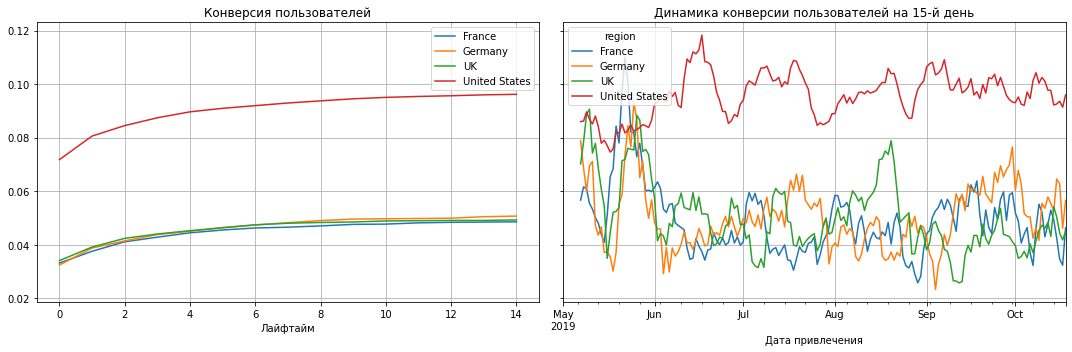

In [37]:
# [],['region'],['device'],['channel']    
result_raw_from_conversion, result_grouped_from_conversion, result_in_time_from_conversion = get_conversion(
    profiles, purchases, observation_date, horizon_days, dimensions=['region'])
    
plot_conversion(result_grouped_from_conversion, result_in_time_from_conversion, 15)

Промежуточный вывод: визуализация конверсии построена.

Необходимо отметить, что конверсия дифференцированная по странам весьма различна: по США достигает 9% за первые две недели, а по другим странам достигает едва 5%.

#### По устройствам
Сделаем визуализацию показателя конверсии с дифференциацией по странам:

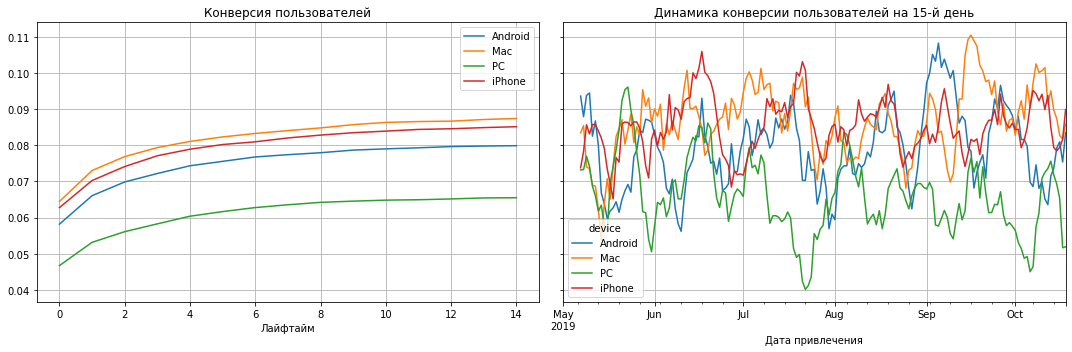

In [38]:
# [],['region'],['device'],['channel']    
result_raw_from_conversion, result_grouped_from_conversion, result_in_time_from_conversion = get_conversion(
    profiles, purchases, observation_date, horizon_days, dimensions=['device'])
    
plot_conversion(result_grouped_from_conversion, result_in_time_from_conversion, 15)

Промежуточный вывод: визуализация конверсии построена.

Пользователи, использующие персональные компьютеры, имеют несколько меньшую конверсию (6,5% за 14 дней), чем пользователи с других устройств (8-9%).

#### По источникам

Сделаем визуализацию показателя конверсии с дифференциацией по источникам пользователей:

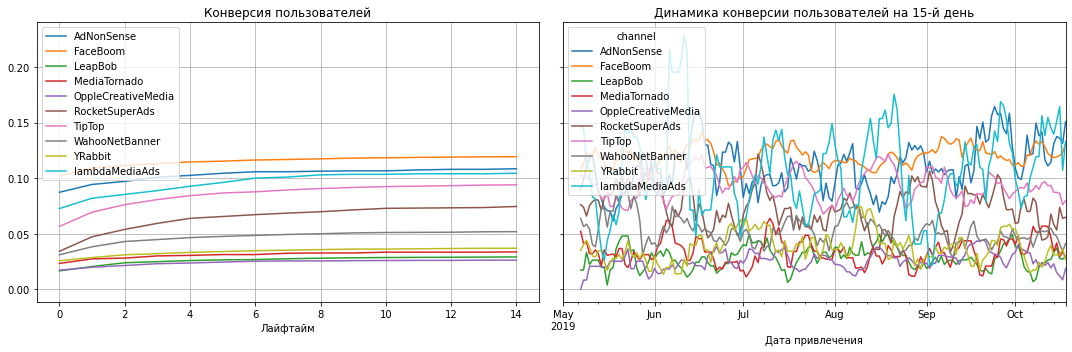

In [39]:
# [],['region'],['device'],['channel']    
result_raw_from_conversion, result_grouped_from_conversion, result_in_time_from_conversion = get_conversion(
    profiles, purchases, observation_date, horizon_days, dimensions=['channel'])
    
plot_conversion(result_grouped_from_conversion, result_in_time_from_conversion, 15)

Промежуточный вывод: графики построены. 
Наибольшая конверсия у таких источников, как FaceBoom, AdNonSense, lambdaMediaAds, TipTop, наименьшая у OppleCreativeMedia и LeapBob.

### Окупаемость 
#### Общая
Сделаем визуализацию окупаемости проекта в целом: 

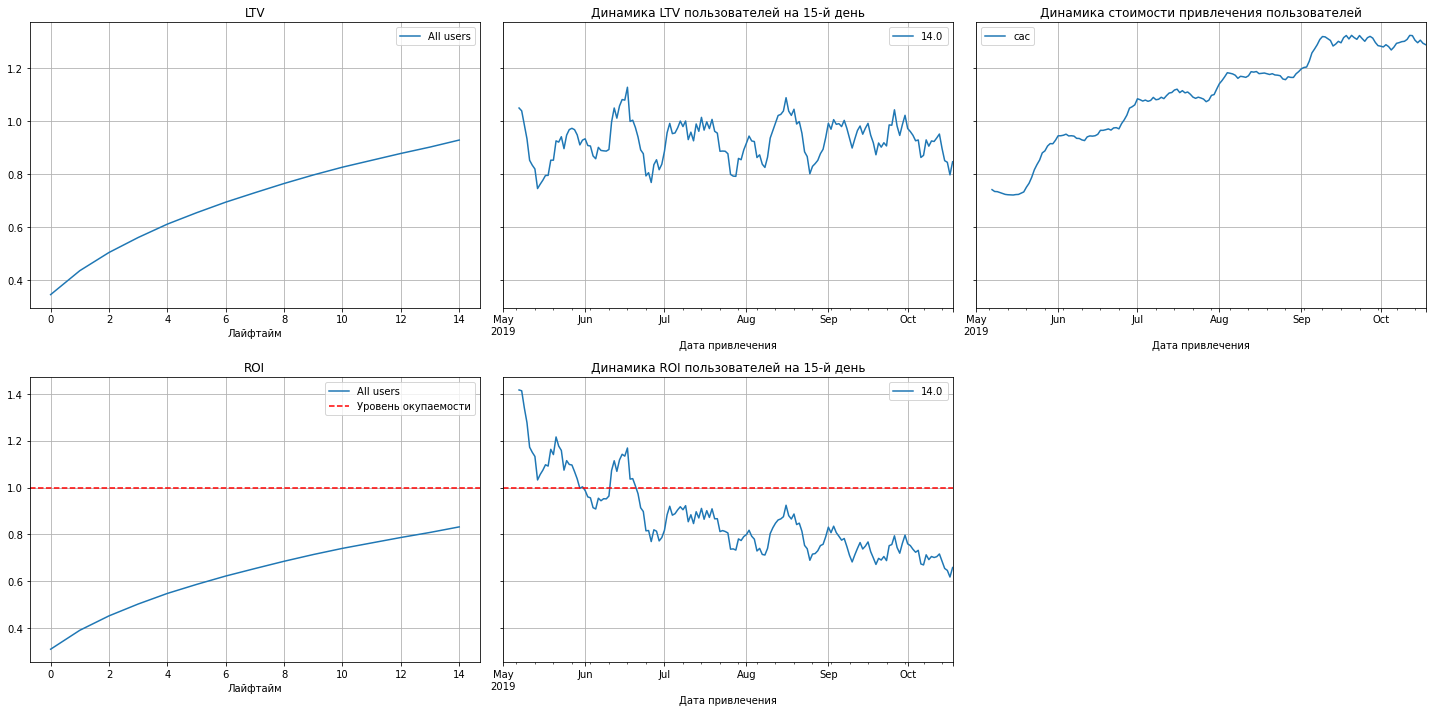

In [40]:
# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 
    
# [],['region'],['device'],['channel']    
result_raw_from_roi, result_grouped_from_roi, result_in_time_from_roi, roi_grouped, roi_in_time = get_ltv(
    profiles, purchases, observation_date, horizon_days, dimensions=[])
    
plot_ltv_roi(result_grouped_from_roi, result_in_time_from_roi, roi_grouped, roi_in_time, 15)

Промежуточный вывод: графики выручки и окупаемости пользователей построены.
Заметно, что до первых чисел июня 2019 года стоимость привлечения пользователей была низкая (до 0,4 доллара), а окупаемость высокая (1,9-1,2). Затем стоимость привлечения стала возрастать с 0,6 до 0,7-0,85 долларов за среднестатистического пользователя, при этом окупаемость ROI упала до 0,9-0,8 единиц.

В среднем за период окупаемость низкая, на 14 день показатель ROI достигает 1,0 (т.е в среднем за период выручка не превышает затраты на рекламу), следовательно проект не окупаем.

#### По странам

Построим таблицу окупаемости с дифференциацией по странам и сделаем визуализацию этих данных и выведем график на экран:

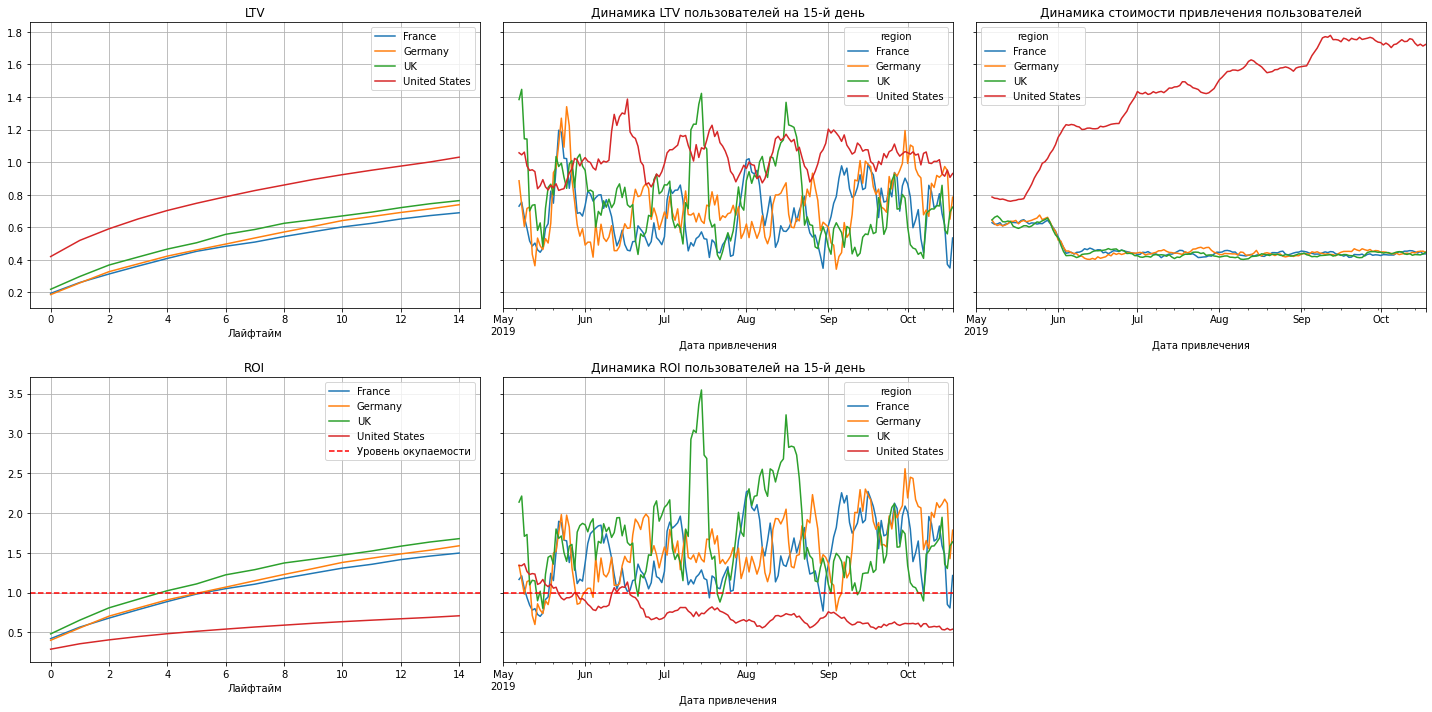

In [41]:
# [],['region'],['device'],['channel']    
result_raw_from_roi, result_grouped_from_roi, result_in_time_from_roi, roi_grouped, roi_in_time = get_ltv(
    profiles, purchases, observation_date, horizon_days, dimensions=['region'])
    
plot_ltv_roi(result_grouped_from_roi, result_in_time_from_roi, roi_grouped, roi_in_time, 15)

Промежуточный вывод: графики окупаемости с дифференциаией по странам построены.
Как видно из графика, низкая окупаемость по привлечению пользователей из США (с июля ROI падает до 0,8-0,5). Причина этого в том, что два из трех проблематичных канала - 'TipTop' и 'FaceBoom' (именно на них было затрачено большая часть денежных средств для привлечения пользователей), характерны именно для США.

#### По устройствам
Построим таблицу окупаемости с дифференциацией по устройствам и выведем график на экран:

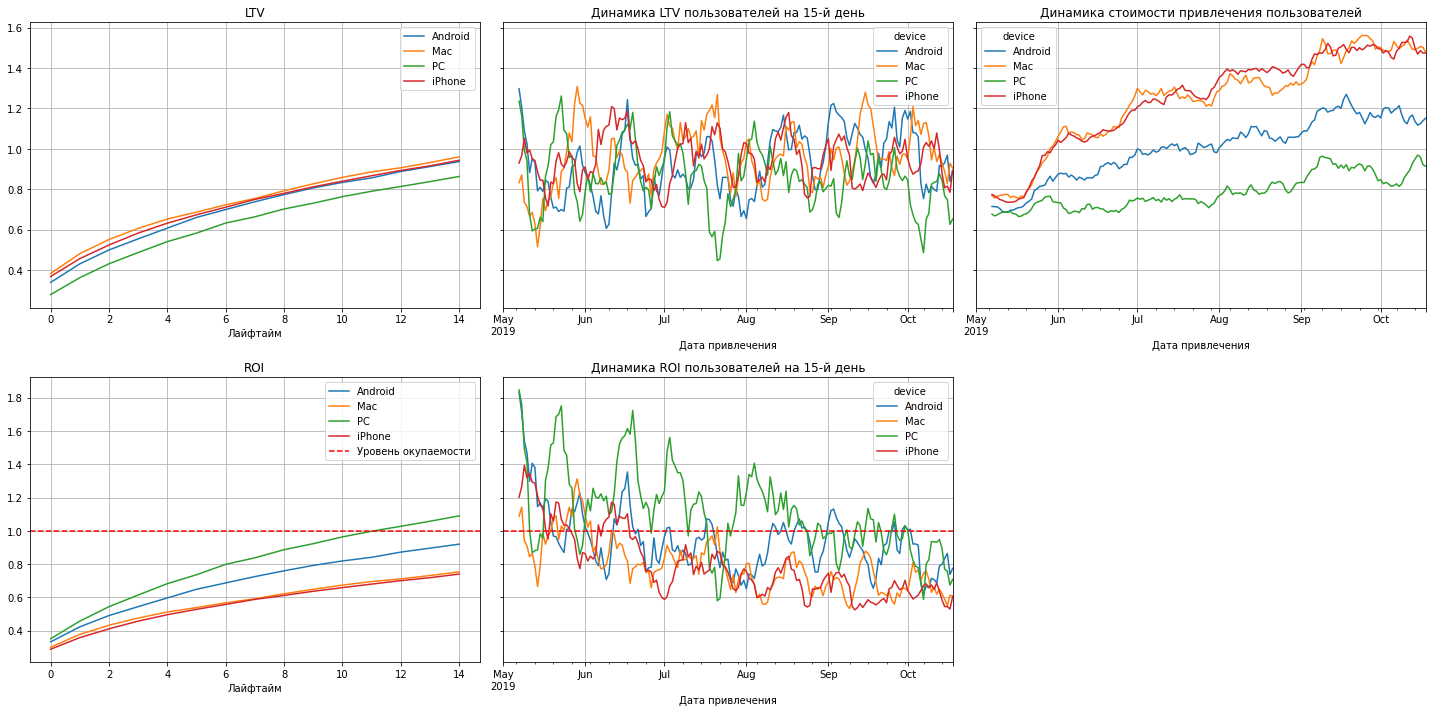

In [42]:
# [],['region'],['device'],['channel']    
result_raw_from_roi, result_grouped_from_roi, result_in_time_from_roi, roi_grouped, roi_in_time = get_ltv(
    profiles, purchases, observation_date, horizon_days, dimensions=['device'])
    
plot_ltv_roi(result_grouped_from_roi, result_in_time_from_roi, roi_grouped, roi_in_time, 15)

Промежуточный вывод: Графики окупаемости с дифференциацией по устройствам построены.
Наиболее высокая окупаемость пользователей, использующих персональные компьютеры, средняя у пользователей мобильных устройств с операционной системой Андроид, а наименьшая окупаемость у пользователей, использующих устройства Mac и iPhone.
Примечательно, что окупаемость покупателей, использующих персональные компьютеры, даже в конце периода была положительной.

#### По источникам

Построим таблицу окупаемости с дифференциацией по каналам и выведем график на экран:

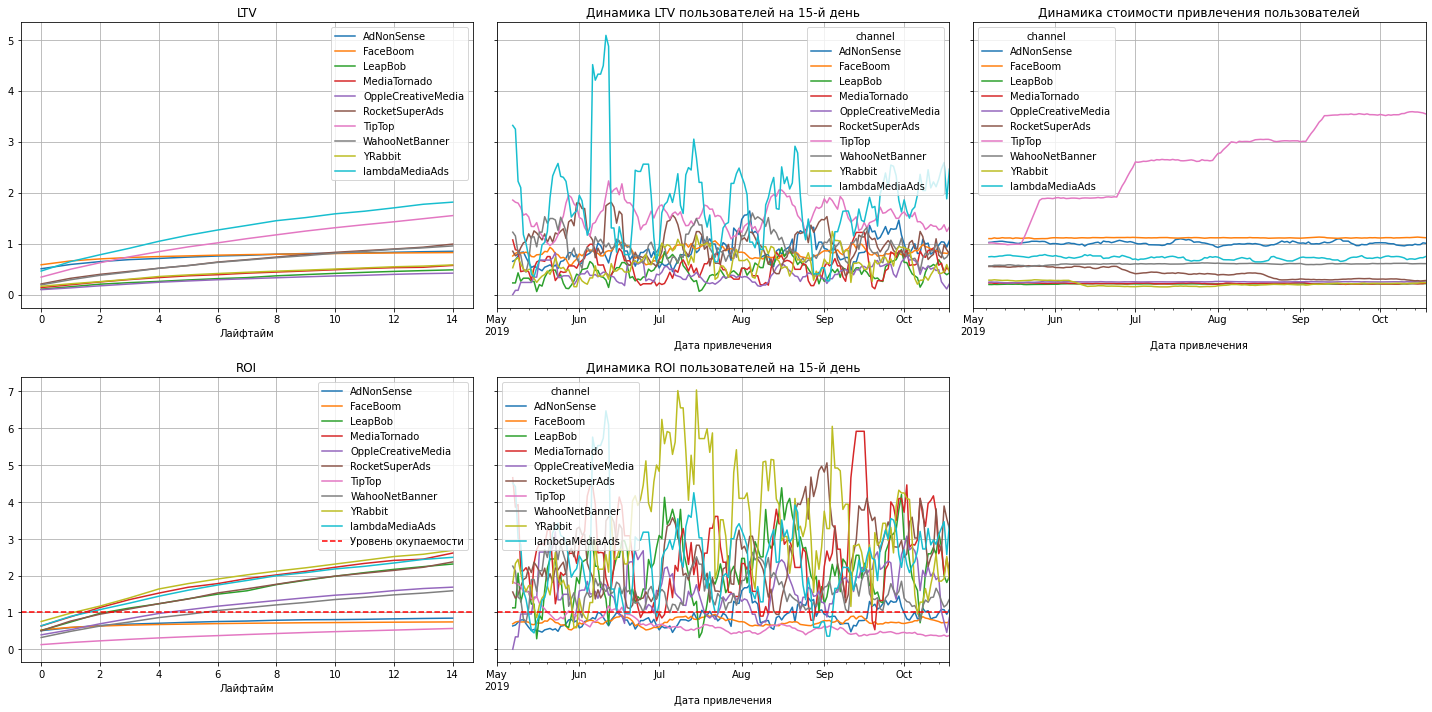

In [43]:
# [],['region'],['device'],['channel']    
result_raw_from_roi, result_grouped_from_roi, result_in_time_from_roi, roi_grouped, roi_in_time = get_ltv(
    profiles, purchases, observation_date, horizon_days, dimensions=['channel'])
    
plot_ltv_roi(result_grouped_from_roi, result_in_time_from_roi, roi_grouped, roi_in_time, 15)

Антирейтинг с самой низкой окупаемостью возглавляет канал 'TipTop' и 'FaceBoom' из США и 'AdNonSense', характерный для Германии, Франции и Великобритании.

К числу сомнительных относятся 'WahooNetBanner' и 'OppleCreativeMedia': поскольку в данном случае окупаемость рассчитывается как соотношение выручки от продажи товаров к затратам на рекламу, то привлечение пользователей с выручкой в размере 2,0 доллара/чел при затратах на рекламу в размере 0,6 доллара/чел (пользователи из источника 'WahooNetBanner' из Франции) может быть убыточным, если из средней выручки в размере 2,0 доллара/чел себестоимость составляет 1,5 доллара/чел.

#### Проблематичные каналы на устройствах

В связи с обнаружением проблемных источников, характерных для определенных стран, напрашивается предположение, что, возможно, низкие показатели по некоторым источникам связаны с некорректной работой приложения на некоторых устройствах (а на других устройствах, возможно, все хорошо), в связи с чем представляется необходимым построение окупаемости по данным проблемным источникам с дифференциацией по устройствам. Профильтруем имеющиеся профили пользователей и проведем расчет окупаемости:

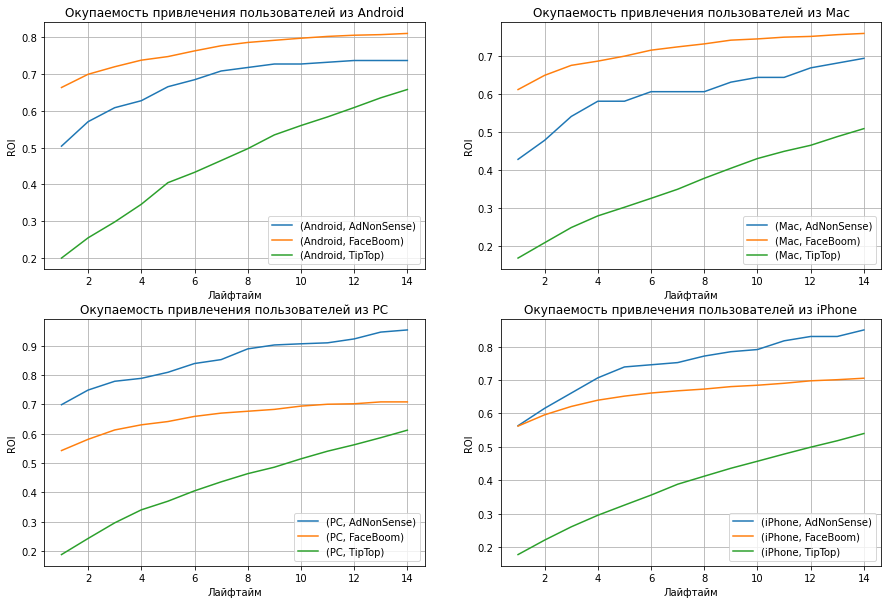

In [44]:
profiles_d = profiles.query('channel in ["AdNonSense", "FaceBoom", "TipTop"]') # фильтруем уже имеющийся profiles
#print('profiles_device:')
#print(profiles_device.head(10))

result_raw_from_roi_d, result_grouped_from_roi_d, result_in_time_from_roi_d, roi_grouped_d, roi_in_time_d = get_ltv(
        profiles_d, purchases, observation_date, horizon_days, dimensions=['device','channel'])

#display(result_raw_from_roi_device.head(10))
#display(roi_grouped_device.head(10))
#display(roi_in_time_device.head(10))

def plot_retention(retention, retention_history, horizon, window=7):
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))
    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]
    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
#    if retention.index.nlevels == 1:
#        retention['cohort'] = 'All users'
#        retention = retention.reset_index().set_index(['cohort', 'payer'])
 
    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    list_title = ['Окупаемость привлечения пользователей из Android',
                  'Окупаемость привлечения пользователей из Mac',
                  'Окупаемость привлечения пользователей из PC',
                  'Окупаемость привлечения пользователей из iPhone']
    list_query = ['device == "Android"',
                  'device == "Mac"',
                  'device == "PC"',
                  'device == "iPhone"']
    for i in [0,1,2,3]:    
        ax1 = plt.subplot(2, 2, i+1)
        retention.query(list_query[i]).drop(columns=['cac']).T.plot(grid=True, ax=ax1)
        plt.legend()
        plt.ylabel('ROI')
        plt.xlabel('Лайфтайм')
        plt.title(list_title[i])
plot_retention(roi_grouped_d, roi_in_time_d, 15)

Промежуточный итог: хотя графики окупаемости несколько отличаются по разным устройствам, однако все они лежат в диапазоне менее единицы. Следовательно, проблема не в корректности работы приложения на различных устройствах, а в самих источниках.

## Выводы

По итогам проведенной работы выявлено следующее:
- Компания терпит убытки (в период с мая до конца октября 2019 года ROI снизился с 1,8 до 0,8 единиц), причина этого - привлечение пользователей из источников 'FaceBoom' и 'TipTop' (из США), а также 'AdNonSense' (из Франции, Великобритании и Германии). 
- Привлечение пользователей из дорогих источников 'WahooNetBanner' и 'OppleCreativeMedia' сомнительно и может быть убыточным (в данном случае окупаемость рассчитывается как соотношение выручки от продажи товаров к затратам на рекламу, и не исключено, что затраты на рекламу превышают разницу между выручкой и себестоимостью). По этим источникам необходима дополнительная проработка с менеджерами компании.
- Выделяется крайне низкое удержание пользователей из источников 'FaceBoom' и 'AdNonSense' (оба предоставляют пользователей из США), удержание которых примерно в 6 раз ниже удержания из других источников. Доля источника 'FaceBoom' по привлечению платящих пользователей составляет 46%, а 'AdNonSense' всего 5,7 % (не считая organic). Большой удельный вес источника 'FaceBoom' снижает среднее удержание пользователей из США, так и среднее удержание пользователей по всему проекту в целом. Данные источники представляются некачественными.
- Рекомендуется отказаться от трафика из источника 'FaceBoom' и 'AdNonSense', а также из источника 'TipTop', если не представляется возможным снижения стоимости привлечения пользователей из этого источника.